In [4]:
!pip install summa

In [5]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.9.1
2.18.0
2.2.2
1.2.0


In [6]:
from bs4 import BeautifulSoup
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention
import requests
from summa.summarizer import summarize

## Step 1. 데이터 수집하기

In [7]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [8]:
data.sample(10)

,headlines,text
54792,"After Kohli's reception, Dhoni attends Salman'...",Former India captain MS Dhoni attended Bollywo...
41183,Kejriwal apologises to Arun Jaitley over defam...,Delhi Chief Minister Arvind Kejriwal and other...
96417,Carrie Lam becomes the first female leader of ...,Hong Kong's electoral committee has chosen Car...
9932,Telangana CM has assets worth Ã¢ÂÂ¹22.6 crore...,According to the affidavit submitted by Telang...
8194,Won't listen to journo murder tape as it's in ...,US National Security Advisor John Bolton has s...
94321,European People's Party calls for EU-wide ban ...,"The Europe Parliament's biggest group, Europea..."
2227,"Robbers kill 80-yr-old woman, chop her legs to...",Robbers in Gujarat's Chhotaudepur on Saturday ...
76716,Inform cases of communicable disease onboard t...,Aviation regulator Directorate General of Civi...
78801,Hizbul chief claims they can target any part o...,Terrorist group Hizbul Mujahideen chief Syed S...
65296,France to fine men on spot for harassing women...,France has announced that a new law would impo...


1. 추상적 요약
    - text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있음.
2. 추출적 요약
    - 오직 text열만을 사용.

## Step 2. 데이터 전처리하기 (추상적 요약)

In [9]:
# 1. 데이터 수 보기
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [10]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [11]:
# 데이터프레임의 drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거할 수 있음.
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [12]:
# 데이터에 Null 값이 남아있는지 확인
print(data.isnull().sum())
# Null 값이 있는 행 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


#### 텍스트 정규화와 불용어 제거

In [13]:
# 텍스트 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [14]:
# 불용어 다운로드
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

In [18]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headline)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [19]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

# 훈련 데이터의 Text 컬럼을 반복하면서 전처리
clean_text = list(map(lambda x: preprocess_sentence(x, remove_stopwords=True), data['text']))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [20]:
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_headlines = []

clean_headlines = list(map(lambda x: preprocess_sentence(x, remove_stopwords=False), data['headlines']))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [21]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [22]:
data.isnull().sum()

,0
headlines,0
text,0


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


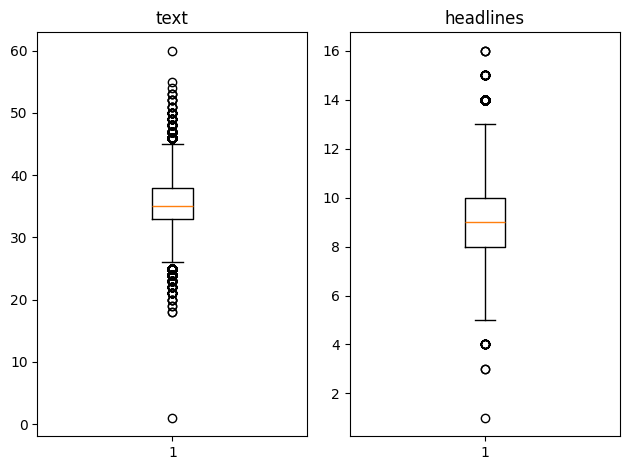

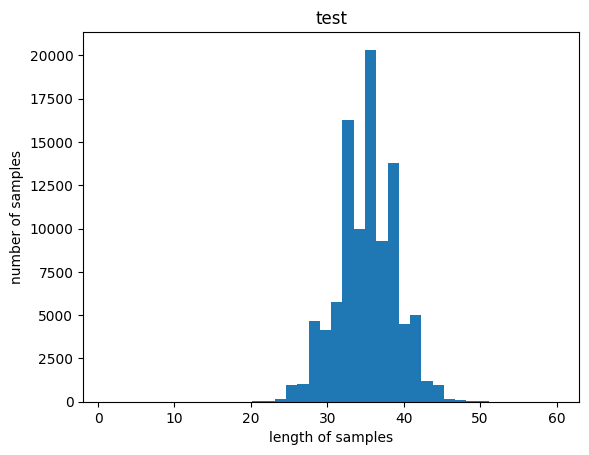

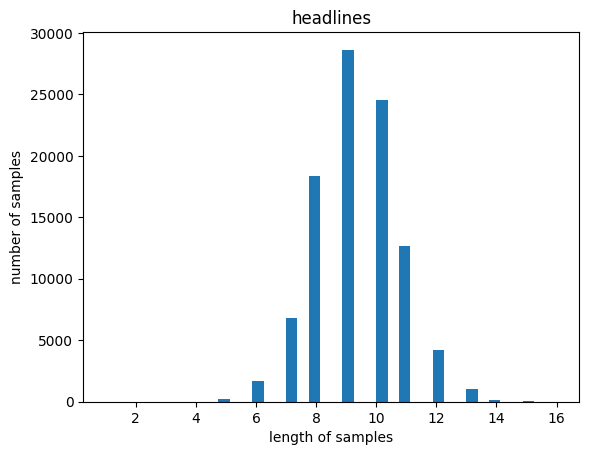

In [23]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('test')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
text_max_len = 42
headlines_max_len = 11

In [25]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [26]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 42 이하인 샘플의 비율: 0.9750305002033347
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [27]:
# 조건에 맞는 샘플만 필터링
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len) &
            data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 90643


In [28]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [29]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [30]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[35913 46257 34177 ... 69332 49065 71187]


In [31]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [32]:
# 나눠야할 테이커의 크기를 계산
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18128


In [33]:
# 계산한 크기만큼 훈련 데이터와 테스트 데이터를 나누어 저장
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 72515
훈련 레이블의 개수 : 72515
테스트 데이터의 개수 : 18128
테스트 레이블의 개수 : 18128


In [34]:
# Keras의 토크나이저를 사용하여 단어 집합을 만들
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [35]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67009
등장 빈도가 6번 이하인 희귀 단어의 수: 45744
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21265
단어 집합에서 희귀 단어의 비율: 68.26545687892671
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.666947419653552


In [36]:
# 단어 집합의 크기를 8,000으로 제한
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [37]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1516, 133, 1273, 2933, 1, 112, 3256, 1968, 68, 1214, 2091, 8374, 1243, 52, 3178, 2279, 307, 131, 196, 1, 1516, 1005, 1094, 199, 17, 189, 112, 1029, 162, 1516, 9574, 112, 6, 12006, 407, 3353, 1068, 4], [389, 467, 450, 77, 473, 2216, 178, 570, 16744, 69, 161, 255, 2735, 3887, 48, 28, 58, 570, 46, 15, 2165, 2736, 5022, 375, 2329, 1312, 947, 50, 21], [12, 1667, 4927, 59, 836, 292, 21, 691, 330, 418, 429, 3523, 2648, 181, 54, 429, 21, 330, 76, 1, 1674, 1870, 790, 11000, 7711, 4927, 2829, 5848, 95, 8, 1, 651, 2830, 4927, 1756, 215, 10763]]


In [38]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [39]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29212
등장 빈도가 5번 이하인 희귀 단어의 수: 19230
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9982
단어 집합에서 희귀 단어의 비율: 65.82911132411337
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.0183613530621995


In [40]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 84, 2982, 2256, 13, 598, 40, 568, 4, 248, 716, 71], [1, 293, 126, 141, 9, 1595, 86, 4, 414, 169], [1, 3050, 185, 201, 3894, 62, 13, 2513, 439, 470], [1, 1242, 45, 682, 3, 4759, 932, 50, 2577, 637], [1, 2257, 106, 12, 2983, 559, 2514, 1440]]
target
decoder  [[84, 2982, 2256, 13, 598, 40, 568, 4, 248, 716, 71, 2], [293, 126, 141, 9, 1595, 86, 4, 414, 169, 2], [3050, 185, 201, 3894, 62, 13, 2513, 439, 470, 2], [1242, 45, 682, 3, 4759, 932, 50, 2577, 637, 2], [2257, 106, 12, 2983, 559, 2514, 1440, 2]]


In [41]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 72514
훈련 레이블의 개수 : 72514
테스트 데이터의 개수 : 18128
테스트 레이블의 개수 : 18128


In [42]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
1. 인코더 설계
2. 디코더 설계
3. 연결 시키기

In [43]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)

In [44]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 42, 128)   │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 42, 256), │    394,240 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 42, 256), │    525,312 │ lstm[0][0]        │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │  1,024,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 42, 256), │    525,312 │ lstm_1[0][0]      │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    394,240 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 256) │        256 │ lstm_3[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 512) │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  4,104,000 │ concat_layer[0][… │
│                     │ 8000)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,527,360 (36.34 MB)

 Trainable params: 9,527,360 (36.34 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 177s 568ms/step - loss: 6.5032 - val_loss: 5.7743
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 197s 565ms/step - loss: 5.8049 - val_loss: 5.6762
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 159s 561ms/step - loss: 5.7090 - val_loss: 5.5906
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 201s 557ms/step - loss: 5.6296 - val_loss: 5.4863
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 203s 560ms/step - loss: 5.4990 - val_loss: 5.3508
Epoch 6/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 201s 556ms/step - loss: 5.3643 - val_loss: 5.2401
Epoch 7/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 201s 554ms/step - loss: 5.2430 - val_loss: 5.1689
Epoch 8/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 202s 553ms/step - loss: 5.1432 - val_loss: 5.0630
Epoch 9/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 202s 553ms/step - loss: 5.0500 - val_loss: 4.9941
Epoch 10/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 157s 552ms/step - loss: 4.9692 - val_loss: 4.9262
Epoch 11/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 203s 555ms/step - loss: 4.8799 - val_loss: 4.8461
Epoch 12

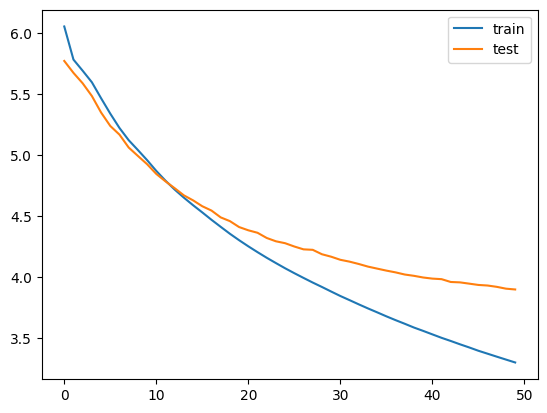

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [47]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

훈련된 모델을 이제 실제 사용 가능하게 인코더와 디코더로 분리하기.

In [48]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [49]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

디코더가 출력을 지속하게 할 수 있는 단어 시퀀스 함수를 만들기!

In [53]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주기.
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [54]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i!=0 and i!=tar_word_to_index['sostoken'] and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [55]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : bsp supremo mayawati death apple executive said chief minister would first taken action involved cops met victim family way round like cm accused government serious demanded accused officer prosecuted 
실제 요약 : would have taken action first mayawati on apple exec death 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
예측 요약 :  apple mp to death in mp murder case


원문 : jamaica eight time olympic gold medalist usain bolt undergoing trial australian football club already given trials clubs germany norway south africa bolt trained german club borussia dortmund last season joining australia league central coast mariners indefinite training period 
실제 요약 : usain

## Step 5. Summa을 이용해서 추출적 요약해보기

In [56]:
text = '''
SEOUL, April 10 (Yonhap) -- South Korean stocks rallied 6.6 percent Thursday as the U.S. administration's temporary pause of reciprocal tariffs on South Korea improved market sentiment. The Korean won was trading sharply higher against the U.S. dollar.

The benchmark Korea Composite Stock Price Index (KOSPI) soared 151.36 points, or 6.6 percent, to close at 2,445.06, sharply rebounding from the 17-month low the previous day.

Shortly after the stock market opened, the bourse operator issued a sidecar order at 9:06 a.m., halting program purchasing for five minutes, after the KOSPI 200 futures soared 5 percent for more than one minute.

Trade volume was a bit heavy at 661 million shares worth 10.9 trillion won (US$7.5 billion), with winners far outperforming losers 873 to 47.

Foreigners and institutions purchased local shares worth 324.4 billion won and 676.2 billion won, respectively, while retail investors dumped a combined 1.07 trillion won.

Overnight, Wall Street posted one of the best days since the global financial crisis in 2008, with the S&P 500 surging 9.5 percent, the Dow Jones Industrial Average soaring 7.87 percent and the tech-heavy Nasdaq composite skyrocketing 12.16 percent.

The rally came after U.S. President Donald Trump lowered new tariffs on South Korea and other trading partners to 10 percent in what he calls a pause that will last for 90 days.

He said the decision was made considering they have reached out to U.S. trade officials for negotiations and have not retaliated against the reciprocal tariffs.

Meanwhile, Trump increased duties on China to 125 percent following Beijing's announcement of a plan to raise tariffs on U.S. goods to 84 percent in a retaliatory move.

"Concerns turned to relief after the Trump announced a 90-day pause of reciprocal tariffs for countries other than China," Lee Kyoung-min, an analyst at Daishin Securities, said.

"Shares related to semiconductor, defense, electricity and mobile phone components, in particular, led the KOSPI's sharp rebound," he added.
'''

In [57]:
print(text[:1500])


SEOUL, April 10 (Yonhap) -- South Korean stocks rallied 6.6 percent Thursday as the U.S. administration's temporary pause of reciprocal tariffs on South Korea improved market sentiment. The Korean won was trading sharply higher against the U.S. dollar.

The benchmark Korea Composite Stock Price Index (KOSPI) soared 151.36 points, or 6.6 percent, to close at 2,445.06, sharply rebounding from the 17-month low the previous day.

Shortly after the stock market opened, the bourse operator issued a sidecar order at 9:06 a.m., halting program purchasing for five minutes, after the KOSPI 200 futures soared 5 percent for more than one minute.

Trade volume was a bit heavy at 661 million shares worth 10.9 trillion won (US$7.5 billion), with winners far outperforming losers 873 to 47.

Foreigners and institutions purchased local shares worth 324.4 billion won and 676.2 billion won, respectively, while retail investors dumped a combined 1.07 trillion won.

Overnight, Wall Street posted one of the

In [58]:
print('Summary:')
print(summarize(text, ratio=0.15))

Summary:
The rally came after U.S. President Donald Trump lowered new tariffs on South Korea and other trading partners to 10 percent in what he calls a pause that will last for 90 days.


In [59]:
print('Summary:')
print(summarize(text, ratio=0.15, split=True))

Summary:
['The rally came after U.S. President Donald Trump lowered new tariffs on South Korea and other trading partners to 10 percent in what he calls a pause that will last for 90 days.']


In [60]:
print('Summary:')
print(summarize(text, words=50))

Summary:
SEOUL, April 10 (Yonhap) -- South Korean stocks rallied 6.6 percent Thursday as the U.S. administration's temporary pause of reciprocal tariffs on South Korea improved market sentiment.
The rally came after U.S. President Donald Trump lowered new tariffs on South Korea and other trading partners to 10 percent in what he calls a pause that will last for 90 days.
